# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 13, 15, 20, 47, 318218)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next two lines for local development
with open('../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1158295
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=2,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=3,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='7.172867E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'int'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features   </span>



In [7]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=2,
)
last_three_days = air_quality_fg.read()
last_three_days = last_three_days.sort_values('date', ascending=False).head(3)
print(last_three_days)

weather_fg = fs.get_feature_group(
    name='weather',
    version=2,
)
weather_batch_data = weather_fg.filter(weather_fg.date >= today).read()
weather_batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.35s) 
                          date  pm25 country            city   street  \
3453 2024-11-13 00:00:00+00:00  20.0   italy  emilia-romagna  gavello   
3449 2024-11-12 00:00:00+00:00  70.0   italy  emilia-romagna  gavello   
3444 2024-11-11 00:00:00+00:00  65.0   italy  emilia-romagna  gavello   

                                    url  pm25_3day_mean  pm25_3day_trend  
3453  https://api.waqi.info/feed/@10009       51.666667             22.5  
3449  https://api.waqi.info/feed/@10009       78.000000            -12.0  
3444  https://api.waqi.info/feed/@10009       83.666667             -1.0  
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,season
0,2024-11-21 00:00:00+00:00,27.200001,0.2,12.599998,53.130020,emilia-romagna,3
1,2024-11-20 00:00:00+00:00,28.350000,0.0,17.114204,67.750931,emilia-romagna,3
2,2024-11-22 00:00:00+00:00,26.850000,1.2,11.013882,78.690102,emilia-romagna,3
3,2024-11-19 00:00:00+00:00,28.000000,0.0,22.450264,74.180748,emilia-romagna,3
4,2024-11-18 00:00:00+00:00,28.400000,0.1,23.400000,59.489841,emilia-romagna,3
5,2024-11-16 00:00:00+00:00,28.150000,0.0,14.973577,62.818974,emilia-romagna,3
6,2024-11-15 00:00:00+00:00,28.200001,0.0,19.665359,66.250504,emilia-romagna,3
7,2024-11-17 00:00:00+00:00,27.400000,0.1,18.391737,49.763721,emilia-romagna,3
8,2024-11-14 00:00:00+00:00,28.500000,0.0,16.595179,65.658920,emilia-romagna,3


## <span style="color:#ff5f27;"> 🖍 Initialize Air Quality batch data </span>

In [8]:
#print(last_three_days)
aq_batch_data = pd.DataFrame()

# Add predicted PM2.5 values to the DataFrame
aq_batch_data['predicted_pm25'] = [None] # Initialize the column with None

#print(aq_batch_data)

aq_batch_data['pm25_3day_mean'] = last_three_days['pm25'].mean()

# 2. Trend of PM2.5 for the Previous Three Days
# Function to calculate the slope of the line fitting the last 3 points
def calculate_slope(data):
    if len(data) < 3:
        return np.nan
    x = np.array([0, 1, 2]).reshape(-1, 1)
    y = data.values.reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    return model.coef_[0][0]

aq_batch_data['pm25_3day_trend'] = calculate_slope(last_three_days['pm25'])

# Add the date, country, city, street, and URL to the DataFrame
aq_batch_data['date'] = tomorrow
aq_batch_data['country'] = country
aq_batch_data['city'] = city
aq_batch_data['street'] = street
aq_batch_data['url'] = last_three_days['url'].values[0]

# Display the updated DataFrame with new features
aq_batch_data

,predicted_pm25,pm25_3day_mean,pm25_3day_trend,date,country,city,street,url
0,None,51.666668,22.5,2024-11-14 15:20:47.318218,italy,emilia-romagna,gavello,https://api.waqi.info/feed/@10009


## <span style="color:#ff5f27;"> 🖍 Merge data batch to obtain the final forecast features </span>

In [9]:
# Join the weather data with the air quality data on city
batch_data = pd.merge(
    aq_batch_data[['predicted_pm25', 'pm25_3day_mean', 'pm25_3day_trend', 'city']], 
    weather_batch_data, 
    on='city', 
    how='inner')

# Reorder the columns to match the training data
cols = [
    'pm25_3day_mean', 
    'pm25_3day_trend',  
    'temperature_2m_mean', 
    'precipitation_sum', 
    'wind_speed_10m_max', 
    'wind_direction_10m_dominant', 
    'season']
batch_data = batch_data[cols]

batch_data

,pm25_3day_mean,pm25_3day_trend,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,season
0,51.666668,22.5,27.200001,0.2,12.599998,53.130020,3
1,51.666668,22.5,28.350000,0.0,17.114204,67.750931,3
2,51.666668,22.5,26.850000,1.2,11.013882,78.690102,3
3,51.666668,22.5,28.000000,0.0,22.450264,74.180748,3
4,51.666668,22.5,28.400000,0.1,23.400000,59.489841,3
5,51.666668,22.5,28.150000,0.0,14.973577,62.818974,3
6,51.666668,22.5,28.200001,0.0,19.665359,66.250504,3
7,51.666668,22.5,27.400000,0.1,18.391737,49.763721,3
8,51.666668,22.5,28.500000,0.0,16.595179,65.658920,3


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [10]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(batch_data)
batch_data

,pm25_3day_mean,pm25_3day_trend,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,season,predicted_pm25
0,51.666668,22.5,27.200001,0.2,12.599998,53.130020,3,74.454010
1,51.666668,22.5,28.350000,0.0,17.114204,67.750931,3,59.054134
2,51.666668,22.5,26.850000,1.2,11.013882,78.690102,3,61.773697
3,51.666668,22.5,28.000000,0.0,22.450264,74.180748,3,75.974457
4,51.666668,22.5,28.400000,0.1,23.400000,59.489841,3,80.047920
5,51.666668,22.5,28.150000,0.0,14.973577,62.818974,3,68.099533
6,51.666668,22.5,28.200001,0.0,19.665359,66.250504,3,67.408669
7,51.666668,22.5,27.400000,0.1,18.391737,49.763721,3,68.165642
8,51.666668,22.5,28.500000,0.0,16.595179,65.658920,3,66.573593


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   pm25_3day_mean               9 non-null      float32
 1   pm25_3day_trend              9 non-null      float64
 2   temperature_2m_mean          9 non-null      float32
 3   precipitation_sum            9 non-null      float32
 4   wind_speed_10m_max           9 non-null      float32
 5   wind_direction_10m_dominant  9 non-null      float32
 6   season                       9 non-null      int64  
 7   predicted_pm25               9 non-null      float32
dtypes: float32(6), float64(1), int64(1)
memory usage: 488.0 bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [12]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
batch_data['date'] = weather_batch_data['date']
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data = batch_data.sort_values(by=['date'])
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data

,pm25_3day_mean,pm25_3day_trend,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,season,predicted_pm25,street,city,country,date,days_before_forecast_day
8,51.666668,22.5,28.500000,0.0,16.595179,65.658920,3,66.573593,gavello,emilia-romagna,italy,2024-11-14 00:00:00+00:00,1
6,51.666668,22.5,28.200001,0.0,19.665359,66.250504,3,67.408669,gavello,emilia-romagna,italy,2024-11-15 00:00:00+00:00,2
5,51.666668,22.5,28.150000,0.0,14.973577,62.818974,3,68.099533,gavello,emilia-romagna,italy,2024-11-16 00:00:00+00:00,3
7,51.666668,22.5,27.400000,0.1,18.391737,49.763721,3,68.165642,gavello,emilia-romagna,italy,2024-11-17 00:00:00+00:00,4
4,51.666668,22.5,28.400000,0.1,23.400000,59.489841,3,80.047920,gavello,emilia-romagna,italy,2024-11-18 00:00:00+00:00,5
3,51.666668,22.5,28.000000,0.0,22.450264,74.180748,3,75.974457,gavello,emilia-romagna,italy,2024-11-19 00:00:00+00:00,6
1,51.666668,22.5,28.350000,0.0,17.114204,67.750931,3,59.054134,gavello,emilia-romagna,italy,2024-11-20 00:00:00+00:00,7
0,51.666668,22.5,27.200001,0.2,12.599998,53.130020,3,74.454010,gavello,emilia-romagna,italy,2024-11-21 00:00:00+00:00,8
2,51.666668,22.5,26.850000,1.2,11.013882,78.690102,3,61.773697,gavello,emilia-romagna,italy,2024-11-22 00:00:00+00:00,9


In [13]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 8 to 2
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   pm25_3day_mean               9 non-null      float32            
 1   pm25_3day_trend              9 non-null      float64            
 2   temperature_2m_mean          9 non-null      float32            
 3   precipitation_sum            9 non-null      float32            
 4   wind_speed_10m_max           9 non-null      float32            
 5   wind_direction_10m_dominant  9 non-null      float32            
 6   season                       9 non-null      int64              
 7   predicted_pm25               9 non-null      float32            
 8   street                       9 non-null      object             
 9   city                         9 non-null      object             
 10  country                      9 non-null      object        

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-13 15:21:50,366 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



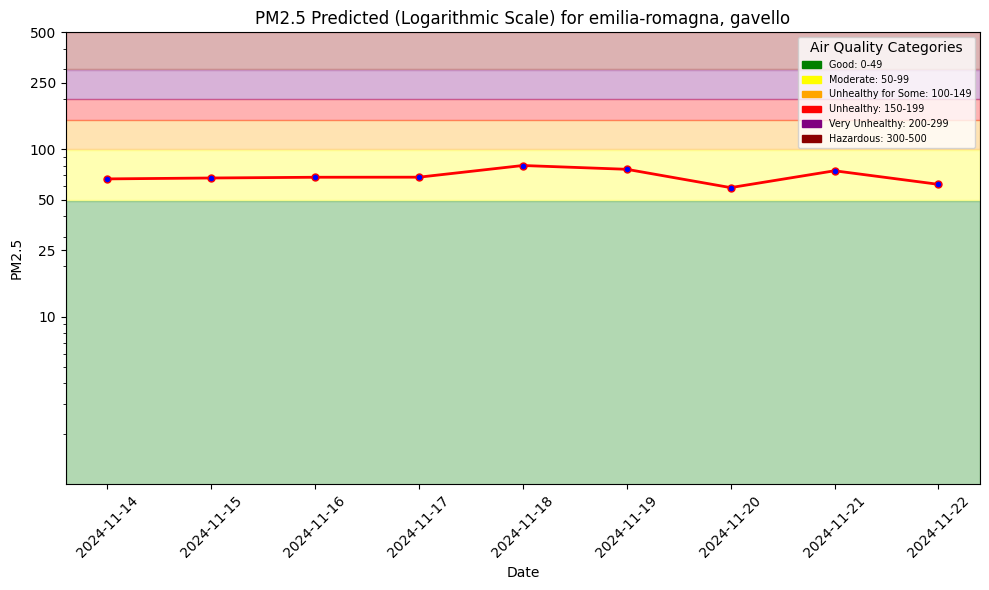

In [14]:
file_path = "../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [18]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring (enhanced predictive power)',
    version=2,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [19]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1158295/jobs/named/aq_predictions_2_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fe53c473190>, None)

In [20]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.76s) 


,pm25_3day_mean,pm25_3day_trend,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,season,predicted_pm25,street,city,country,date,days_before_forecast_day
0,51.666668,22.5,28.5,0.0,16.595179,65.65892,3,66.573593,gavello,emilia-romagna,italy,2024-11-14 00:00:00+00:00,1


In [24]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=2,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.27s) 


,date,pm25,country,city,street,url,pm25_3day_mean,pm25_3day_trend
0,2016-05-31 00:00:00+00:00,50.0,italy,emilia-romagna,gavello,https://api.waqi.info/feed/@10009,64.333333,-7.5
1,2021-06-07 00:00:00+00:00,30.0,italy,emilia-romagna,gavello,https://api.waqi.info/feed/@10009,41.333333,-14.0
2,2016-07-18 00:00:00+00:00,85.0,italy,emilia-romagna,gavello,https://api.waqi.info/feed/@10009,58.000000,4.0
3,2016-10-25 00:00:00+00:00,119.0,italy,emilia-romagna,gavello,https://api.waqi.info/feed/@10009,78.333333,12.0
4,2022-02-28 00:00:00+00:00,70.0,italy,emilia-romagna,gavello,https://api.waqi.info/feed/@10009,59.333333,-28.5
...,...,...,...,...,...,...,...,...
3452,2024-11-07 00:00:00+00:00,61.0,italy,emilia-romagna,gavello,https://api.waqi.info/feed/@10009,60.666667,15.0
3453,2024-11-13 00:00:00+00:00,20.0,italy,emilia-romagna,gavello,https://api.waqi.info/feed/@10009,51.666667,22.5
3454,2024-11-05 00:00:00+00:00,68.0,italy,emilia-romagna,gavello,https://api.waqi.info/feed/@10009,52.333333,-11.5
3455,2024-11-06 00:00:00+00:00,72.0,italy,emilia-romagna,gavello,https://api.waqi.info/feed/@10009,53.333333,9.0


In [25]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
#if len(hindcast_df) == 0:
    #hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

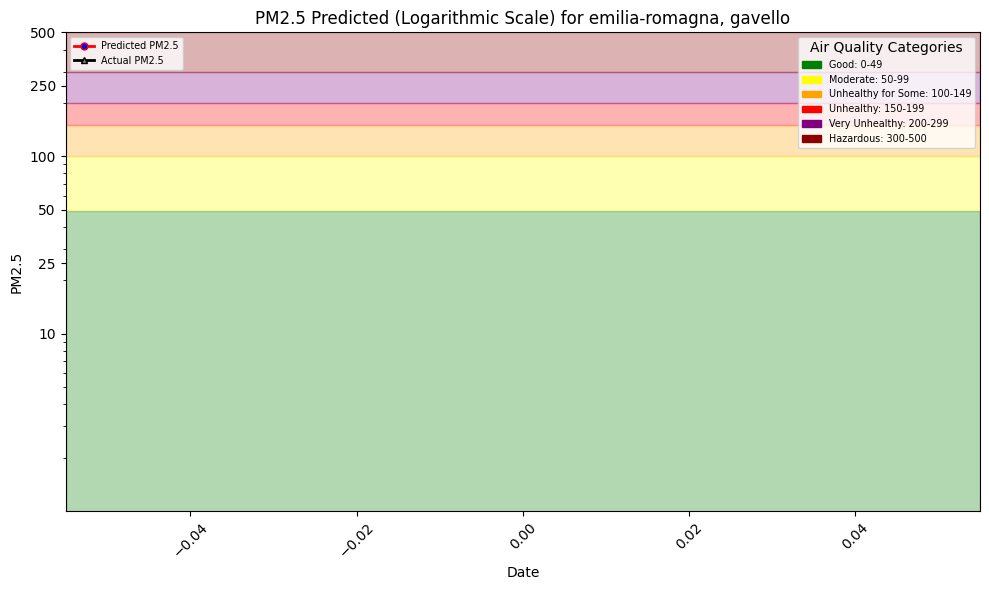

In [26]:
file_path = "../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---